## Metrics of the classification using k-NN with embeddings
`test_index.py`

In [1]:
import json
import pandas as pd

from pathlib import Path
from collections import Counter, namedtuple, defaultdict

from sklearn.metrics import (
    precision_score, 
    recall_score,
    accuracy_score, 
    balanced_accuracy_score
    )


Load data from experiment

In [6]:
PATH_TRAIN=Path("/data/bacteria/experiments/autoencoders/6mer/07012024-1")

# load labels for train+val and test
with open(f"{PATH_TRAIN}/split-train-val-test.json","r") as fp:
    datasets = json.load(fp)

In [7]:
ID_assemblies = [Path(p).stem for p in  datasets["id_labels"]["test"]]
ID_assemblies[:2]

['SAMN02441568', 'SAMN10267441']

In [8]:
# collect info in a dataframe
InfoLabels = namedtuple("InfoLabels",["label","dataset","count"])
counts = dict()
data = []
for ds in ["train","val","test"]:
    count = Counter(datasets["labels"][ds])
    for specie, count in count.items():
        data.append(
            InfoLabels(specie, ds, count)
        )

df_infolabels = pd.DataFrame(data)

# get dict with count for the test set for later evaluation
counts_test = dict()
for idx, sp, ds, count in df_infolabels.query("dataset == 'test'").to_records("record"):
    counts_test[sp] = count

counts_train = defaultdict(int)
for idx, sp, ds, count in df_infolabels.query("dataset != 'test'").to_records("record"):
    counts_train[sp] += count

#### load assigned labels by k-NN using embeddings and faiss index
- Columns named `consensus_<k>` correspond to the label assigned by majority vote using the `k` retrieved embeddings for each query.
- The column `GT` correspond to the true label of the query.

In [16]:
df = pd.read_csv(PATH_TRAIN.joinpath("test/query_results.csv"), index_col=0)

In [20]:
from collections import Counter
cols_labels = [c for c in df.columns if c.startswith("label")]
df["consensus"] = df[cols_labels].apply(lambda row: Counter(row).most_common(1)[0][0],axis=1)

In [31]:
df.head()

,sample_id_query,sample_id_0,label_0,distance_to_0,sample_id_1,label_1,distance_to_1,sample_id_2,label_2,distance_to_2,...,sample_id_7,label_7,distance_to_7,sample_id_8,label_8,distance_to_8,sample_id_9,label_9,distance_to_9,consensus
0,SAMN02441568,SAMN02194931,dustbin,0.001107,SAMN02198867,dustbin,0.017639,SAMN02198995,dustbin,0.028683,...,SAMEA3643099,dustbin,0.034283,SAMN04515666,dustbin,0.035693,SAMN08775159,dustbin,0.036177,dustbin
1,SAMN10267441,SAMN03890380,escherichia_coli,0.000583,SAMN05323709,escherichia_coli,0.000759,SAMN07569132,escherichia_coli,0.000759,...,SAMN03769910,escherichia_coli,0.000999,SAMN07823480,escherichia_coli,0.001032,SAMN07519293,escherichia_coli,0.001043,escherichia_coli
2,SAMEA2796503,SAMEA2446104,streptococcus_pneumoniae,0.001219,SAMEA2238627,streptococcus_pneumoniae,0.001577,SAMEA2814374,streptococcus_pneumoniae,0.001604,...,SAMEA4561461,streptococcus_pneumoniae,0.002193,SAMEA4024468,streptococcus_pneumoniae,0.002401,SAMEA3180615,streptococcus_pneumoniae,0.002438,streptococcus_pneumoniae
3,SAMEA4023184,SAMEA2554321,streptococcus_pneumoniae,0.001548,SAMEA4024654,streptococcus_pneumoniae,0.002290,SAMEA4561343,streptococcus_pneumoniae,0.002426,...,SAMN02737984,streptococcus_pneumoniae,0.002754,SAMEA4388167,streptococcus_pneumoniae,0.002780,SAMEA1026655,streptococcus_pneumoniae,0.002944,streptococcus_pneumoniae
4,SAMEA1713299,SAMN02737965,streptococcus_pneumoniae,0.002170,SAMEA867844,streptococcus_pneumoniae,0.002295,SAMEA1408325,streptococcus_pneumoniae,0.002320,...,SAMEA2061732,streptococcus_pneumoniae,0.002565,SAMN02737990,streptococcus_pneumoniae,0.002565,SAMEA3381572,streptococcus_pneumoniae,0.002566,streptococcus_pneumoniae


In [29]:
labels_test = datasets["labels"]["test"]
sample_id_test = [Path(p).stem for p in datasets["id_labels"]["test"]]
df_test = pd.DataFrame({"sample_id": sample_id_test, "ground_truth": labels_test})

In [34]:
df = pd.merge(left=df, right=df_test, left_on="sample_id_query", right_on="sample_id")

In [35]:
classes = df.ground_truth.unique()
classes = sorted(classes)
y_true, y_pred = df.ground_truth, df.consensus

In [36]:
accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred), len(classes)

(0.9871321552743826, 0.9082148965325019, 143)

In [37]:
precision = precision_score(y_true, y_pred, average=None, labels=classes)
recall = recall_score(y_true, y_pred, average=None, labels=classes)

/home/avila/micromamba/envs/train/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
data_metrics = []
Metrics = namedtuple("Metrics", ["label","n_queries", "n_index", "precision","recall"])
for sp, prec, rec in zip(classes, precision, recall):
    n_queries= counts_test[sp]
    n_index = counts_train[sp]
    data_metrics.append(
        Metrics(sp, n_queries, n_index, prec, rec)
    )

In [39]:
df_metrics = pd.DataFrame(data_metrics).sort_values(by=["recall"])
df_metrics.sort_values("label").sort_values(by="precision").head(15)

,label,n_queries,n_index,precision,recall
129,streptococcus_sp_group_b,14,131,0.000000,0.000000
16,brucella_melitensis,25,226,0.294118,0.200000
109,shigella_flexneri,71,638,0.433333,0.183099
77,mycobacterium_bovis,23,209,0.500000,0.043478
17,brucella_suis,14,126,0.500000,0.142857
15,brucella_abortus,49,445,0.530120,0.897959
64,lactobacillus_casei,13,121,0.666667,0.769231
45,enterobacter_cloacae,120,1081,0.712871,0.600000
46,enterobacter_hormaechei,130,1172,0.720000,0.830769
79,mycobacterium_intracellulare,15,133,0.750000,0.600000


In [40]:
df_metrics.describe()

,n_queries,n_index,precision,recall
count,143.000000,143.000000,143.000000,143.000000
mean,390.195804,3511.734266,0.926668,0.908215
std,1450.463691,13053.675264,0.143586,0.186583
min,10.000000,90.000000,0.000000,0.000000
25%,15.000000,135.000000,0.914474,0.904091
50%,28.000000,248.000000,0.994382,0.981132
75%,74.500000,670.500000,1.000000,1.000000
max,13733.000000,123593.000000,1.000000,1.000000


___ 

### Confusion Matrix

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
N_SAMPLES=15

<Figure size 2500x2500 with 0 Axes>

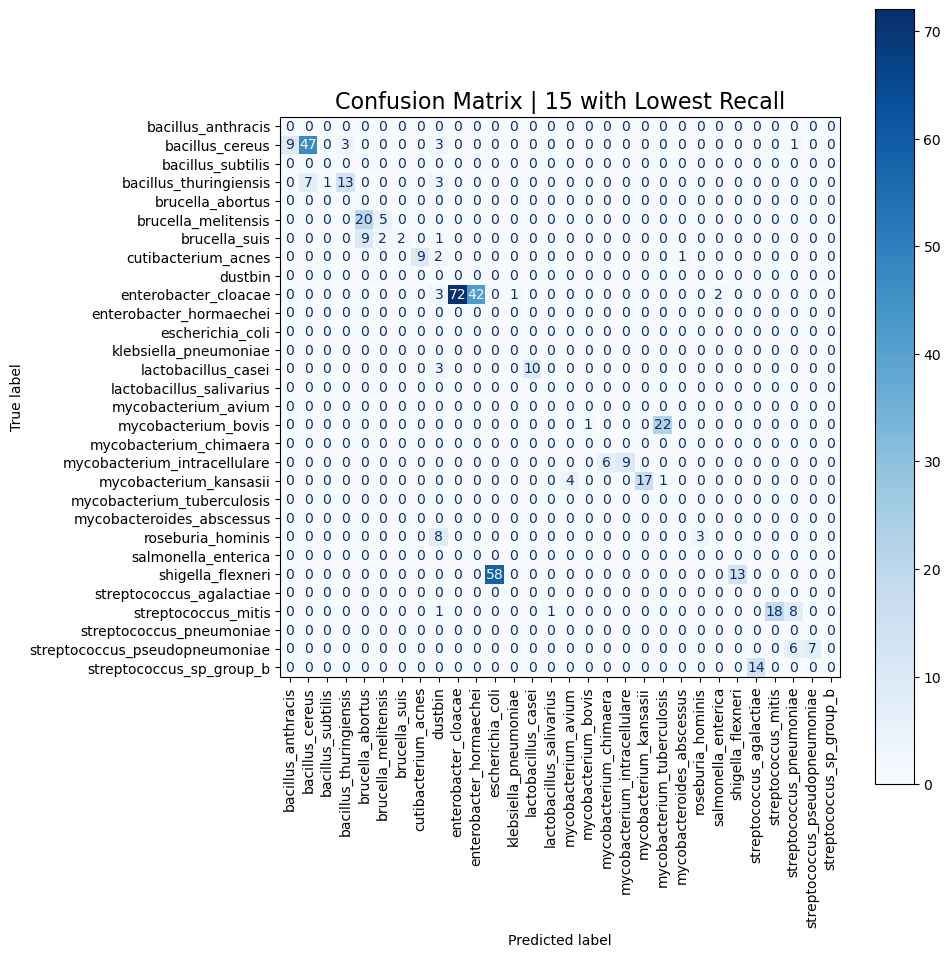

In [44]:

labels_to_plot = df_metrics.sort_values(by="recall")["label"].tolist()[:N_SAMPLES]
filter_df = df.query(f"ground_truth in {(labels_to_plot)}")

y_true = filter_df.ground_truth.tolist()
y_pred = filter_df.consensus.tolist()

labels = list(set(y_true+y_pred))
# labels = list(set(y_true))
labels.sort()
fig = plt.figure(figsize=(25,25))
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp=ConfusionMatrixDisplay(cm, display_labels=labels,)

disp.plot( cmap=plt.cm.Blues)
fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  
disp.ax_.set_title(f"Confusion Matrix | {N_SAMPLES} with Lowest Recall", fontsize=16, fontweight="medium")
plt.xticks(rotation='vertical')

PATH_SAVE=Path("../plots/6mers/metrics/confusion_matrix_lowest_recall.png") 
PATH_SAVE.parent.mkdir(exist_ok=True, parents=True)

plt.tight_layout()
plt.savefig(PATH_SAVE,dpi=300)

<Figure size 2500x2500 with 0 Axes>

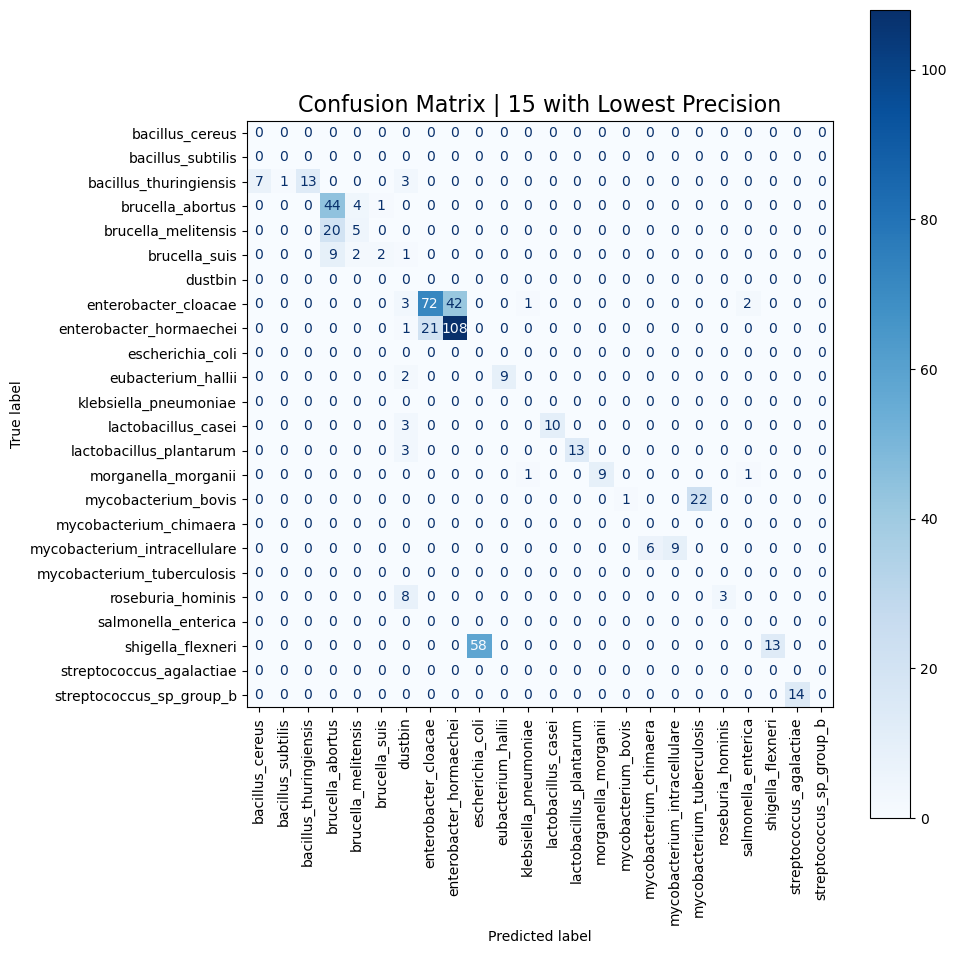

In [45]:
labels_to_plot = df_metrics.sort_values(by="precision")["label"].tolist()[:N_SAMPLES]

filter_df = df.query(f"ground_truth in {(labels_to_plot)}") # and GT != consensus_10")

y_true = filter_df.ground_truth.tolist()
y_pred = filter_df.consensus.tolist()

labels = list(set(y_true+y_pred))
# labels = list(set(y_true))

labels.sort()
fig = plt.figure(figsize=(25,25))
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp=ConfusionMatrixDisplay(cm, display_labels=labels,)

disp.plot( cmap=plt.cm.Blues)
fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  
disp.ax_.set_title(f"Confusion Matrix | {N_SAMPLES} with Lowest Precision", fontsize=16, fontweight="medium")
plt.xticks(rotation='vertical')

PATH_SAVE=Path("../plots/6mers/metrics/confusion_matrix_lowest_precision.png") 
PATH_SAVE.parent.mkdir(exist_ok=True, parents=True)

plt.tight_layout()
plt.savefig(PATH_SAVE,dpi=300)

In [46]:
id_missclassified = df[df.ground_truth != df.consensus].sample_id.tolist()

In [47]:
path="/data/bacteria/File1_full_krakenbracken.txt"
krakenbracken = pd.read_csv(path, sep="\t", usecols=["sample_id","V2","V3","V4","V5","V6","V7"])


In [48]:
krakenbracken.query(f"sample_id in {id_missclassified}").sort_values(by="sample_id")

,sample_id,V2,V3,V4,V5,V6,V7
125,SAMD00004084,Staphylococcus aureus,23.907,Flavobacterium columnare,10.650,Flavobacterium indicum,3.933
416,SAMD00010238,Cronobacter malonaticus,67.082,Cronobacter sakazakii,12.954,Salmonella enterica,9.763
475,SAMD00012381,Corynebacterium ulcerans,98.844,Corynebacterium glutamicum,0.792,Fusarium oxysporum,0.045
677,SAMD00016544,Salmonella enterica,14.457,Enterobacter cloacae,8.112,Escherichia coli,5.212
700,SAMD00016793,Citrobacter werkmanii,88.414,Citrobacter freundii,1.850,Citrobacter freundii complex sp. CFNIH4,1.285
...,...,...,...,...,...,...,...
648739,SAMN10163186,Burkholderia dolosa,87.421,Burkholderia cepacia,3.478,Burkholderia multivorans,1.557
649882,SAMN10182638,Shigella flexneri,56.131,Escherichia coli,39.064,Pseudomonas aeruginosa,1.494
651973,SAMN10238112,Shigella flexneri,51.465,Escherichia coli,46.084,Shigella dysenteriae,0.624
654278,SAMN10264078,Lactobacillus pentosus,71.006,Lactobacillus plantarum,18.559,Lactobacillus fermentum,2.068


In [51]:
df_kraken = krakenbracken.query(f"sample_id in {id_missclassified}").sort_values(by="sample_id",)
df_test = df.query(f"sample_id in {id_missclassified}")[["ground_truth","consensus","sample_id"]].sort_values(by="sample_id",)

In [52]:
df_missclassified_abundance = pd.merge(df_test,df_kraken, left_on="sample_id", right_on="sample_id").sort_values(by="ground_truth")

In [53]:
df_missclassified_abundance["pred_match_second_species"] = df_missclassified_abundance.apply(lambda row: True if row["consensus"] == "_".join(row["V4"].lower().split(" ")) else False, axis=1)

In [61]:
df_missclassified_abundance.sort_values(by=["pred_match_second_species","ground_truth","consensus"], ascending=False).head(10)

,ground_truth,consensus,sample_id,V2,V3,V4,V5,V6,V7,pred_match_second_species
75,yersinia_pseudotuberculosis,yersinia_pestis,SAMEA1712656,Yersinia pseudotuberculosis,74.958,Yersinia pestis,21.262,Yersinia similis,3.054,True
235,yersinia_pseudotuberculosis,yersinia_enterocolitica,SAMEA4011241,Yersinia pseudotuberculosis,77.732,Yersinia enterocolitica,11.286,Yersinia pestis,6.831,True
237,yersinia_pseudotuberculosis,yersinia_enterocolitica,SAMEA4011289,Yersinia pseudotuberculosis,60.580,Yersinia enterocolitica,27.885,Yersinia pestis,10.777,True
333,yersinia_pestis,yersinia_pseudotuberculosis,SAMN02690733,Yersinia pestis,95.956,Yersinia pseudotuberculosis,1.379,Yersinia frederiksenii,0.651,True
37,vibrio_cholerae,morganella_morganii,SAMEA104147951,Vibrio cholerae,72.296,Morganella morganii,26.017,Alteromonas mediterranea,0.519,True
36,vibrio_cholerae,aeromonas_veronii,SAMEA104147922,Vibrio cholerae,54.844,Aeromonas veronii,41.883,Aeromonas hydrophila,0.887,True
28,streptococcus_sp_group_b,streptococcus_agalactiae,SAMEA103956214,Streptococcus sp. 'group B',70.303,Streptococcus agalactiae,28.018,Streptococcus uberis,0.452,True
432,streptococcus_sp_group_b,streptococcus_agalactiae,SAMN04592782,Streptococcus sp. 'group B',70.457,Streptococcus agalactiae,28.609,Streptococcus pyogenes,0.212,True
672,streptococcus_sp_group_b,streptococcus_agalactiae,SAMN09385284,Streptococcus sp. 'group B',74.730,Streptococcus agalactiae,22.629,Streptococcus pyogenes,0.751,True
434,streptococcus_sp_group_b,streptococcus_agalactiae,SAMN04593299,Streptococcus sp. 'group B',66.996,Streptococcus agalactiae,32.144,Streptococcus pyogenes,0.207,True


In [58]:
df_missclassified_abundance.query("pred_match_second_species == False").describe()

,V3,V5,V7
count,290.000000,290.000000,289.000000
mean,46.486672,11.912052,5.889277
std,31.494898,9.177190,5.096943
min,2.250000,0.031000,0.011000
25%,15.465750,4.999250,1.913000
50%,44.359000,9.894500,4.922000
75%,76.041750,17.018250,7.914000
max,99.944000,44.410000,30.389000


In [59]:
df_missclassified_abundance.query("pred_match_second_species == True").describe()

,V3,V5,V7
count,428.000000,428.00000,428.000000
mean,59.473839,26.21321,4.480930
std,19.830555,14.47797,4.958329
min,3.137000,0.18800,0.021000
25%,49.844250,11.85250,0.780000
50%,55.967000,26.53900,2.414000
75%,75.193000,39.64400,6.485000
max,99.603000,48.38600,25.018000
